In [31]:
!pip install openpyxl

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import string
import re

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [33]:
# load data exclude Columna1
df_news = pd.read_excel('data/Noticias.xlsx', usecols='B:F')
df_news.shape

(14396, 5)

In [34]:
df_news.head(2)

,Enlaces,Título,info,contenido,Etiqueta
0,https://www.eltiempo.com/agresion-contra-un-op...,Operador de grúa quedó inconsciente tras agres...,El conductor de una moto le lanzó el casco y p...,Las autoridades están buscando al conductor de...,colombia
1,https://www.eltiempo.com/archivo/documento/CMS...,"Usaquén, primera en infracciones por mal parqueo",La localidad ocupa el primer lugar en comparen...,"""Los andenes son para los peatones"", reclama e...",archivo


In [35]:
df_news.describe()

,Enlaces,Título,info,contenido,Etiqueta
count,14396,14378,11483,13738,14396
unique,14396,13851,11412,13202,26
top,https://www.eltiempo.com/vida/viajar/yovoy-cam...,Caricaturas,"Si no tuvo tiempo para informarse hoy, aquí un...",Manizales 10:00 p.m. Ya se venden medicamentos...,archivo
freq,1,138,12,238,9187


# Exercise 1
Data exploration

In [36]:
category_counts = df_news['Etiqueta'].value_counts()
print(category_counts[:15])

Etiqueta
archivo                9187
colombia                934
deportes                727
opinion                 532
mundo                   446
cultura                 430
economia                367
justicia                343
bogota                  311
vida                    268
politica                252
tecnosfera              214
salud                   106
historias-el-tiempo      57
mundial                  47
Name: count, dtype: int64


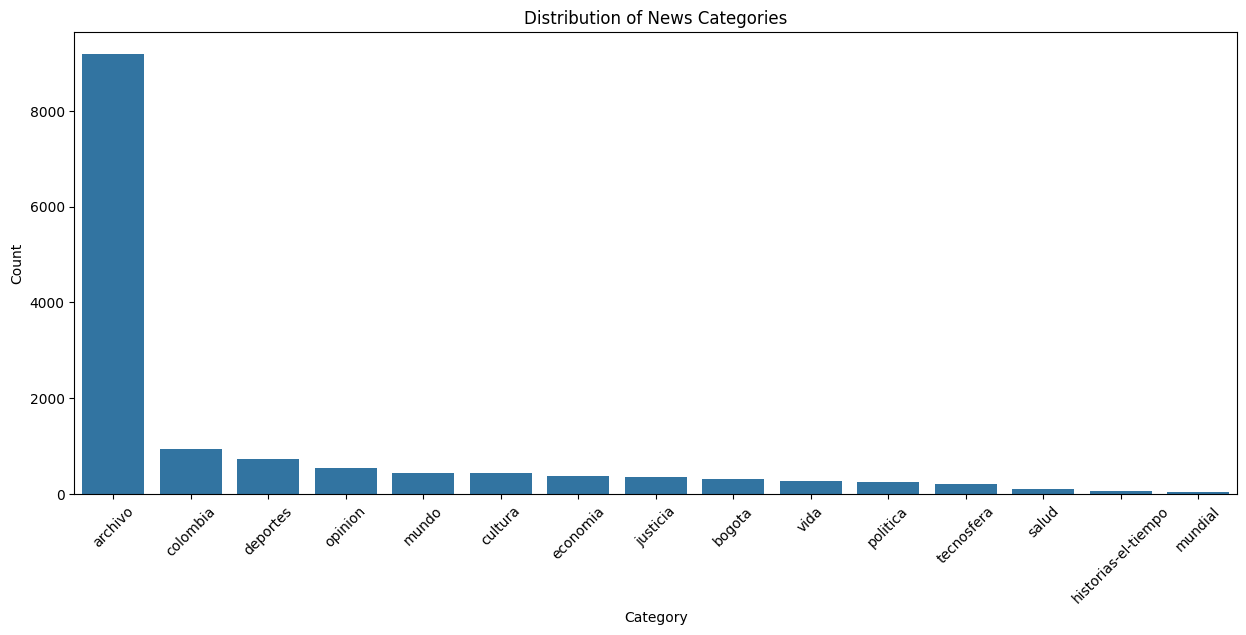

In [37]:
plt.figure(figsize=(15,6))
sns.barplot(x=category_counts.index[:15], y=category_counts.values[:15])
plt.title('Distribution of News Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Exercise 2
Filter by most relevant

In [38]:
# randomly picked 100 as the min threshold
most_relevant_cats = category_counts[(category_counts > 100) & (category_counts < 1000)]
print(most_relevant_cats)

Etiqueta
colombia      934
deportes      727
opinion       532
mundo         446
cultura       430
economia      367
justicia      343
bogota        311
vida          268
politica      252
tecnosfera    214
salud         106
Name: count, dtype: int64


In [39]:
df_filtered = df_news[df_news['Etiqueta'].isin([
    'deportes',
    'cultura',
    'economia',
    'justicia',
    'politica',
    'tecnosfera',
    'salud'
])]
df_filtered.shape

(2439, 5)

# Exercise 3
Data preprocessing

In [40]:
df_preprocessed = df_filtered.copy()
df_preprocessed.shape

(2439, 5)

In [41]:
df_preprocessed = df_preprocessed[['Título', 'info', 'contenido', 'Etiqueta']]
df_preprocessed.shape

(2439, 4)

In [42]:
df_preprocessed = df_preprocessed.dropna()
df_preprocessed.shape

(2386, 4)

In [43]:
df_preprocessed.head(2)

,Título,info,contenido,Etiqueta
10487,"Al interior de, aparte, roquero, rock / El len...",'Al interior de' es el reemplazo sofisticado e...,Citas: “Los crímenes de violencia sexual comet...,cultura
10488,Antonina Canal: 20 años de danza oriental en C...,La bailarina habló con EL TIEMPO de su trayect...,Con motivo de la celebración de los 20 años de...,cultura


In [44]:
df_preprocessed['unified_text'] = 'Título: ' + df_preprocessed['Título'] + '. Resumen: ' + df_preprocessed['info'] + '. Contenido: ' + df_preprocessed['contenido'] + '.'
df_preprocessed.head(2)

,Título,info,contenido,Etiqueta,unified_text
10487,"Al interior de, aparte, roquero, rock / El len...",'Al interior de' es el reemplazo sofisticado e...,Citas: “Los crímenes de violencia sexual comet...,cultura,"Título: Al interior de, aparte, roquero, rock ..."
10488,Antonina Canal: 20 años de danza oriental en C...,La bailarina habló con EL TIEMPO de su trayect...,Con motivo de la celebración de los 20 años de...,cultura,Título: Antonina Canal: 20 años de danza orien...


In [45]:
def preprocess_text(text):
    stripped = text.strip()
    cleaned = re.sub(r'[\n\t]+', ' ', stripped)
    cleaned = re.sub(r'\s{2,}', ' ', cleaned)
    cleaned = re.sub(r'\.{2,}', '.', cleaned)
    return cleaned

In [46]:
df_preprocessed['cleaned_text'] = df_preprocessed['unified_text'].apply(preprocess_text)
df_preprocessed.head(2)

,Título,info,contenido,Etiqueta,unified_text,cleaned_text
10487,"Al interior de, aparte, roquero, rock / El len...",'Al interior de' es el reemplazo sofisticado e...,Citas: “Los crímenes de violencia sexual comet...,cultura,"Título: Al interior de, aparte, roquero, rock ...","Título: Al interior de, aparte, roquero, rock ..."
10488,Antonina Canal: 20 años de danza oriental en C...,La bailarina habló con EL TIEMPO de su trayect...,Con motivo de la celebración de los 20 años de...,cultura,Título: Antonina Canal: 20 años de danza orien...,Título: Antonina Canal: 20 años de danza orien...


In [47]:
# oov token is used to replace the words which are not in the vocabulary (Out Of Vocabulary)
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(df_preprocessed['cleaned_text'])
word_index = tokenizer.word_index
print('Number of unique words:', len(word_index))
print('First 10 words:', dict(list(word_index.items())[:10]))

Number of unique words: 66161
First 10 words: {'<OOV>': 1, 'de': 2, 'la': 3, 'en': 4, 'el': 5, 'que': 6, 'y': 7, 'a': 8, 'del': 9, 'los': 10}


In [48]:
sequences = tokenizer.texts_to_sequences(df_preprocessed['cleaned_text'])
max_length = 256
X = pad_sequences(sequences, maxlen=max_length, padding='post')
cats = df_preprocessed['Etiqueta'].astype('category').cat
y = cats.codes.values
encoded_category = dict(enumerate(cats.categories))

# Exercise 4
Data split

In [49]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Training set size:", X_train.shape, y_train.shape)
print("Validation set size:", X_val.shape, y_val.shape)

Training set size: (1908, 256) (1908,)
Validation set size: (478, 256) (478,)


# Exercise 5
RNN model

In [86]:
num_classes = len(encoded_category)
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)

model_rnn = Sequential()
model_rnn.add(Embedding(
    input_dim=len(word_index) + 1,
    output_dim=100,
    input_length=max_length
))
model_rnn.add(SimpleRNN(
  units=512,
  go_backwards=True,
  dropout=0.1,
  recurrent_dropout=0.1
))
model_rnn.add(Dense(num_classes, activation='softmax'))

model_rnn.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.01),
    metrics=['accuracy']
)
model_rnn.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [87]:
history_rnn = model_rnn.fit(
    X_train,
    y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=30,
    verbose=1
)

Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.1857 - loss: 2.6692 - val_accuracy: 0.1799 - val_loss: 2.0680
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.2157 - loss: 2.0568 - val_accuracy: 0.2950 - val_loss: 1.9386
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.2217 - loss: 2.0243 - val_accuracy: 0.2866 - val_loss: 1.9728
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.2593 - loss: 2.1427 - val_accuracy: 0.2782 - val_loss: 1.9968
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.3047 - loss: 1.8560 - val_accuracy: 0.2385 - val_loss: 2.0149
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.3245 - loss: 1.8419 - val_accuracy: 0.2720 - val_loss: 2.6556
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.3830 - loss: 1.7439 - val_accuracy: 0.2552 - val_loss: 1.9711
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.4023 - loss: 1.6152 - val_accuracy: 0.2636 - v

### Store model

In [88]:
model_rnn.save('models/history_rnn.h5')

# Exercise 6
LSTM model

In [89]:
model_lstm = Sequential()
model_lstm.add(Embedding(
  input_dim=len(word_index) + 1,
  output_dim=100,
  input_length=max_length
))
model_lstm.add(LSTM(units=1024, go_backwards=True))
model_lstm.add(Dense(num_classes, activation='softmax'))

model_lstm.compile(
  loss='categorical_crossentropy',
  optimizer=Adam(learning_rate=0.01),
  metrics=['accuracy']
)
model_lstm.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [90]:
history_lstm = model_lstm.fit(
  X_train,
  y_train_cat,
  validation_data=(X_val, y_val_cat),
  epochs=25,
  batch_size=32
)

Epoch 1/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.2212 - loss: 2.9127 - val_accuracy: 0.2950 - val_loss: 2.0031
Epoch 2/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2107 - loss: 2.0058 - val_accuracy: 0.2950 - val_loss: 1.8715
Epoch 3/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3032 - loss: 1.8486 - val_accuracy: 0.2134 - val_loss: 2.1803
Epoch 4/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4194 - loss: 1.6412 - val_accuracy: 0.2071 - val_loss: 2.1791
Epoch 5/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4323 - loss: 1.6498 - val_accuracy: 0.2657 - val_loss: 2.2629
Epoch 6/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5043 - loss: 1.4057 - val_accuracy: 0.1715 - val_loss: 2.1544
Epoch 7/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5582 - loss: 1.2369 - val_accuracy: 0.2155 - val_loss: 2.3124
Epoch 8/25
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5822 - loss: 1.1778 - val_accuracy: 0.2782 - v

### Store model

In [91]:
model_lstm.save('models/history_lstm.h5')

# Exercise 7
Models evaluation

In [92]:
y_val_pred_rnn = model_rnn.predict(X_val)
y_val_pred_rnn_classes = y_val_pred_rnn.argmax(axis=1)

# LSTM predictions
y_val_pred_lstm = model_lstm.predict(X_val)
y_val_pred_lstm_classes = y_val_pred_lstm.argmax(axis=1)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [93]:
y_encoded_cats = { k: v for k, v in encoded_category.items() if k in set(y_val) }
print(y_encoded_cats)

{0: 'cultura', 1: 'deportes', 2: 'economia', 3: 'justicia', 4: 'politica', 5: 'salud', 6: 'tecnosfera'}


In [94]:
print("RNN Classification Report:")
print(classification_report(y_val, y_val_pred_rnn_classes, target_names=y_encoded_cats.values()))

RNN Classification Report:
              precision    recall  f1-score   support

     cultura       0.18      0.11      0.14        83
    deportes       0.46      0.38      0.42       141
    economia       0.22      0.07      0.10        73
    justicia       0.15      0.12      0.13        68
    politica       0.25      0.06      0.10        50
       salud       0.08      0.19      0.11        21
  tecnosfera       0.09      0.36      0.14        42

    accuracy                           0.20       478
   macro avg       0.20      0.18      0.16       478
weighted avg       0.26      0.20      0.21       478



In [95]:
y_encoded_cats.values()

dict_values(['cultura', 'deportes', 'economia', 'justicia', 'politica', 'salud', 'tecnosfera'])

In [96]:
print("LSTM Classification Report:")
print(classification_report(y_val, y_val_pred_lstm_classes, target_names=y_encoded_cats.values()))

LSTM Classification Report:
              precision    recall  f1-score   support

     cultura       0.28      0.11      0.16        83
    deportes       0.41      0.34      0.37       141
    economia       0.25      0.19      0.22        73
    justicia       0.17      0.18      0.17        68
    politica       0.15      0.36      0.21        50
       salud       0.00      0.00      0.00        21
  tecnosfera       0.04      0.07      0.05        42

    accuracy                           0.22       478
   macro avg       0.19      0.18      0.17       478
weighted avg       0.25      0.22      0.22       478



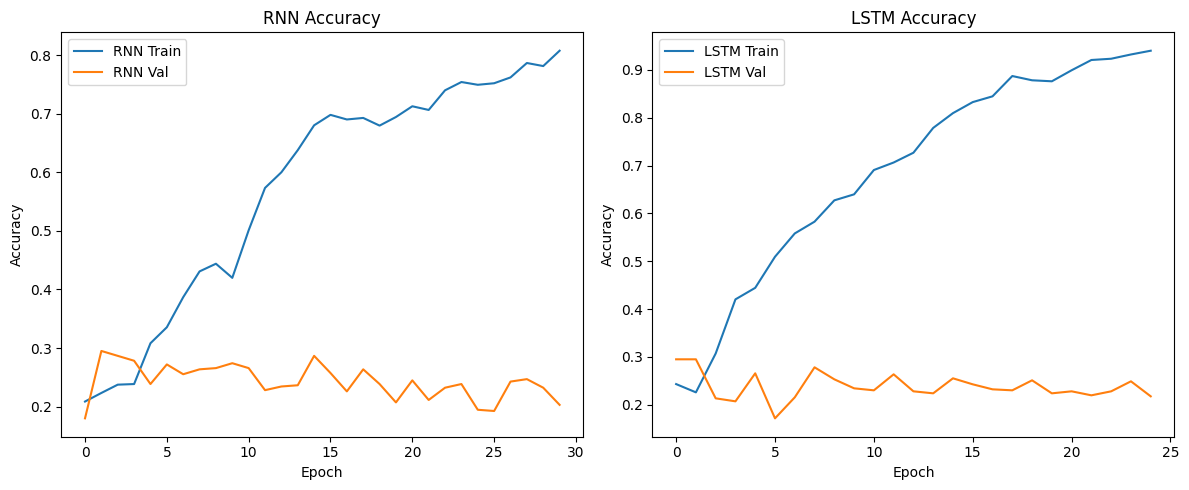

In [97]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['accuracy'], label='RNN Train')
plt.plot(history_rnn.history['val_accuracy'], label='RNN Val')
plt.title('RNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['accuracy'], label='LSTM Train')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM Val')
plt.title('LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Conclusions

Lost dos modelos se comportan bastante bien despues de realizar algunas actualizaciones a la configuracion, el parametro que agrego mas valor al entrenamiento para los dos modelos fue el numero de neuronas, una vez se incremento este valor de la configuracion pasamos de tener un accuracy de alrededor del 30% a 80% para RNN y 90% para LSTM.

Otra observacion en comparacion de los modelos es que LSTM consume muchos menos recursos y realiza el entrenamiento a mayor velocidad, al mismo tiempo que trae mejores resultados.